**Author**: Neel Jay

In this Notebook, I perform EDA on a dataset of airplane strike records. These are typically cases were an aircraft collides with wildlife during flight. During this EDA, I answer some interesting questions about the data and provide some historical context. Overall, it was a good exercise in exploring real-life data without being given a set path forward.

In [ ]:
!apt-get install -qq libgeos-dev libproj-dev

In [ ]:
!pip install basemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 860.7/860.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 16.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.basemap import Basemap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, RegressorMixin

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/data/Airplane Strikes Dataset.csv")

<ipython-input-48-085649084271>:1: DtypeWarning: Columns (9,12,15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/data/Airplane Strikes Dataset.csv")


In [ ]:
df.head()

,Record ID,Incident Year,Incident Month,Incident Day,Operator ID,Operator,Aircraft,Aircraft Type,Aircraft Make,Aircraft Model,...,Fuselage Strike,Fuselage Damage,Landing Gear Strike,Landing Gear Damage,Tail Strike,Tail Damage,Lights Strike,Lights Damage,Other Strike,Other Damage
0,127128,1990,1,1,DAL,DELTA AIR LINES,B-757-200,A,148,26,...,0,0,0,0,1,1,0,0,0,0
1,129779,1990,1,1,HAL,HAWAIIAN AIR,DC-9,A,583,90,...,0,0,0,0,0,0,0,0,1,0
2,129780,1990,1,2,UNK,UNKNOWN,UNKNOWN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,2258,1990,1,3,MIL,MILITARY,A-10A,A,345,NaN,...,0,0,0,0,0,0,0,0,0,0
4,2257,1990,1,3,MIL,MILITARY,F-16,A,561,NaN,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.tail()

,Record ID,Incident Year,Incident Month,Incident Day,Operator ID,Operator,Aircraft,Aircraft Type,Aircraft Make,Aircraft Model,...,Fuselage Strike,Fuselage Damage,Landing Gear Strike,Landing Gear Damage,Tail Strike,Tail Damage,Lights Strike,Lights Damage,Other Strike,Other Damage
174099,366091,2015,9,30,SWA,SOUTHWEST AIRLINES,B-737-700,A,148,42.0,...,0,0,0,0,0,0,0,0,0,0
174100,365902,2015,9,30,SWA,SOUTHWEST AIRLINES,B-737-700,A,148,42.0,...,0,0,0,0,0,0,0,0,0,0
174101,365903,2015,9,30,BUS,BUSINESS,CITATIONJET,A,226,49.0,...,1,1,0,0,0,0,0,0,0,0
174102,366046,2015,9,30,QXE,HORIZON AIR,DHC8 DASH 8,A,303,10.0,...,1,0,0,0,0,0,0,0,0,0
174103,365823,2015,9,30,AWI,AIR WISCONSIN AIRLINES,CRJ100/200,A,188,10.0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# Checking unique values in each column
unique_values = {column: df[column].unique().tolist() for column in df.columns[1:]}

for key in unique_values:
  print(key + ": " + str(unique_values[key]))

Incident Year: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Incident Month: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Incident Day: [1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 9, 10, 14, 22, 27, 31, 17, 16]
Operator ID: ['DAL', 'HAL', 'UNK', 'MIL', 'EME', 'USA', 'BUS', 'SWA', 'PVT', 'UPS', 'EAL', 'USC', 'AAH', 'DLH', 'AAL', 'UAL', 'NWA', 'FDX', 'NHK', 'UNKC', '1AWE', 'AWI', 'ANA', 'LOF', 'COM', 'USCG', 'CTL', 'COA', 'BAW', 'DHL', 'JIA', 'BRG', 'SVA', 'MES', '1AAH', 'PAA', 'BVN', 'HNA', 'EWW', 'ELY', 'MDW', 'GAA', 'AMT', '1ASQ', 'SDU', 'NCC', 'CDL', 'CHQ', 'ALO', 'TWA', 'AMW', 'BTA', 'AJC', 'MTN', 'GOV', 'EGF', 'SKW', 'MEP', 'CFS', 'PHM', 'VGA', 'PDT', 'QXE', 'ASA', 'AJT', 'PEN', 'ASH', 'LHN', 'NAE', 'PLP', 'SYM', 'BSY', 'CNE', 'FXA', 'RBD', 'MRK', 'OAL', 'PJE', 'CDN', 'FSX', 'CKT', 'PXX', 'KLM', 'BOE', 'MTR', 'AXQ', 'AMF', 'NCA', 'SRV', 

# Exploratory Data Analysis

## Motivation

In [ ]:
num_days = df[['Incident Year', 'Incident Month', 'Incident Day']].drop_duplicates().shape[0]
total = df.shape[0]
avg = total / num_days

num_injuries = df[(df['Fatalities'] > 0) | (df['Injuries'] > 0)].shape[0]
percent_injuries = (deaths_or_injuries / total_strikes) * 100

num_damage = df[df['Aircraft Damage'] == 1].shape[0]
percent_damage = (aircraft_damage / total_strikes) * 100

print(f"Avg strikes/day: {avg:.4f}")
print(f"Strikes that result in death or injury: {percent_injuries:.4f}%")
print(f"Strikes that result: {percent_damage:.4f}%")


Avg strikes/day: 18.6128
Strikes that result in death or injury: 0.1378%
Strikes that result: 8.5977%


While a wildlife strike seem like an uncommon senario, it is actually a significant problem. There was an average of 18 reported incidents per day from about 1990-2015.

While only an extremely small proportion of these incidents results in injury, a much larger proportion result in aircraft damage, which can cause delays, emergency landings, etc.

In [ ]:
num_Y = df[df['Warning Issued'] == 'Y'].shape[0]
num_N = df[df['Warning Issued'] == 'N'].shape[0]

total_damage_Y = df[(df['Warning Issued'] == 'Y') & (df['Aircraft Damage'] == 1)].shape[0]
percent_damage_Y = (total_damage_Y / num_Y) * 100

total_damage_N = df[(df['Warning Issued'] == 'N') & (df['Aircraft Damage'] == 1)].shape[0]
percent_damage_N = (total_damage_N / num_N) * 100

print(f'Incidents where warning issed: {num_Y}')
print(f'Incidents where warning not issued: {num_N}')
print(f'Percent damage-incidents when warning issued: {percent_damage_Y:.2f}%')
print(f'Percent damage-incidents when warning not issued: {percent_damage_N:.2f}%')

Incidents where warning issed: 30914
Incidents where warning not issued: 45350
Percent damage-cases when warning issued: 8.82%
Percent damage-cases when warning not issued: 12.60%


We see that the percent of damage causing incidents when a warning isn't issued goes up to 12%. It is almost 4 percent higher than the value for instances where warnings were issued. Thus, being able to give accurate warnings and take necessary precautions seems essential in bringing down the negative affects of wildlife strikes.

## Analysing Patterns/Features

To start out, we can plot the number of incidents over time.

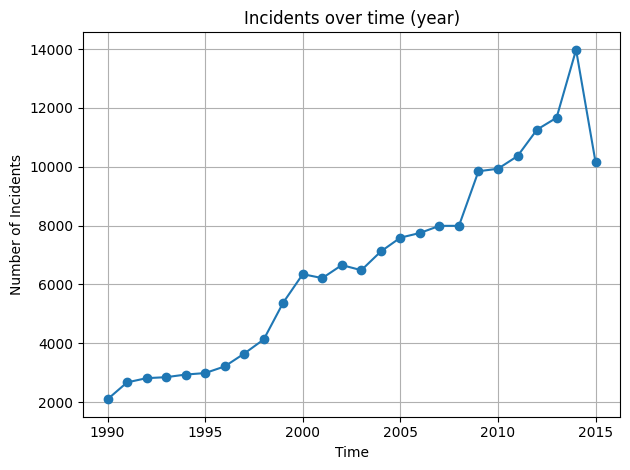

In [ ]:
# Plotting incidents over the years
df.groupby('Incident Year').size().plot(kind='line', marker='o')
plt.title('Incidents over time (year)')
plt.ylabel('Number of Incidents')
plt.xlabel('Time')
plt.grid(True)
plt.tight_layout()
plt.show()

It seems that the amount of incidents has increased about 7x from 1990 to 2014, which is a very large gap in such a short period of time.

While the total has seemingly decreased in 2015, this may be due to the fact that no data were collected after September 2015. Nevertheless, the decrease is significant enough to investigate later on.

For now, I want to understand why there was a strong upwards trend in incidents during this time period. First, it will be useful to understand what types of planes/industries are getting involved in these strikes the most.

One final point of interest is the small number of incidents involving Delta Airlines aircraft. Delta is one of the top domestic flight providers in the US along with Southwest, United, and American. Thus, their lack of prominence in this ranking is significant.

In [ ]:
top_operators = df.groupby('Operator').size().sort_values(ascending=False)
top_operators.head(10)

Operator
UNKNOWN               39540
BUSINESS              14271
SOUTHWEST AIRLINES    13864
UNITED AIRLINES       13207
AMERICAN AIRLINES     10358
MILITARY               8046
FEDEX EXPRESS          6289
DELTA AIR LINES        6155
UPS AIRLINES           4534
1US AIRWAYS            3960
dtype: int64

When sorting by operator type, it seems that the top results are all large commercial air travel companies. It also seems that this data is exclusively from the US, as all the air travel and shipping companies are primarily American.

In [ ]:
top_operators = df.groupby('Aircraft').size().sort_values(ascending=False)
top_operators.head(10)

Aircraft
UNKNOWN       40468
B-737-300      8935
B-737-700      7414
A-320          7073
CRJ100/200     6369
B-757-200      6327
A-319          4501
B-737-800      3588
EMB-145        3584
B-727-200      3136
dtype: int64

When sorting by aircraft type, it seems that almost all top results are aircraft models that are primarily used for commerical passenger travel.

Based off the above results, it may be useful to  look at how the number of commercial flights at US airports changed during this period.

Source: US Beraeu of Transportation Statistics (https://www.transtats.bts.gov/Data_Elements.aspx?Data=1)

Data were only consistently collected from 2003 onwards. From 2003 to 2014, the number of domestic flights went from 9,458,818 to 8,107,803. The number of domestic passengers went from 583,293,766 to 662,826,955.

This would not account for the number of wildlife strike incidents to almost doulbe in the same time.

Increase the Resolution of the time-series data may lead to a better understanding of what is happening.

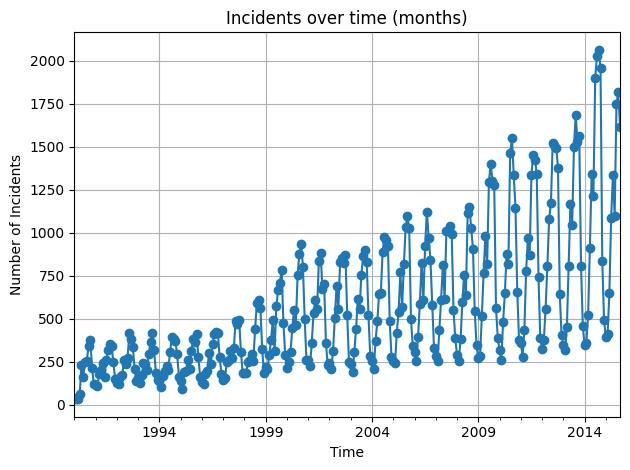

In [ ]:
# Ignored Day column to get a better understanding of behavior by month
df['Date'] = pd.to_datetime(df['Incident Year'].astype(str) + '-' + df['Incident Month'].astype(str) + '-01')
monthly_incidents = df.groupby('Date').size()

# Plotting incidents over the months as a time series
monthly_incidents.plot(kind='line', marker='o')
plt.title('Incidents over time (months)')
plt.ylabel('Number of Incidents')
plt.xlabel('Time')
plt.grid(True)
plt.tight_layout()
plt.show()

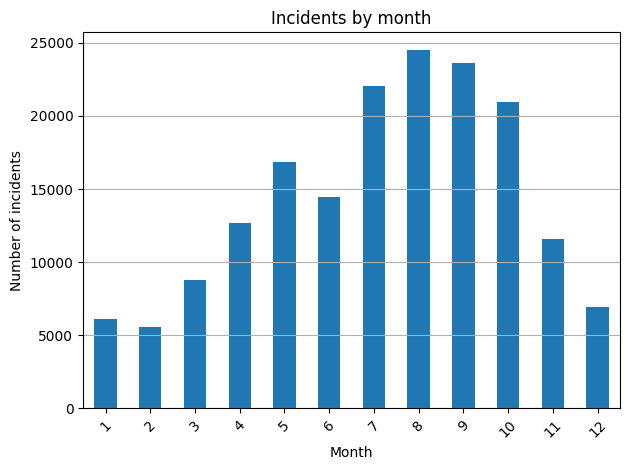

In [ ]:
df.groupby('Incident Month').size().plot(kind='bar')
plt.title('Incidents by month')
plt.ylabel('Number of incidents')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

These two graphs reveal that most of the incidents are happening during the summer and late fall. Minimal incidents are occuring during the winter and early spring. Looking at the time-series data also shows that the number of incidents during the winter has increased very slowly from 1990-2015. However, the number of incidents during the summer increases a lot, which is what dominates the year by year trend.

Let us break down the incidents by state/region.


In [ ]:
state_counts = df['State'].value_counts()

print(state_counts)

TX    14854
CA    13187
FL    10604
NY     9043
IL     7465
      ...  
AB       47
MB       14
NL        7
SK        6
NS        5
Name: State, Length: 62, dtype: int64


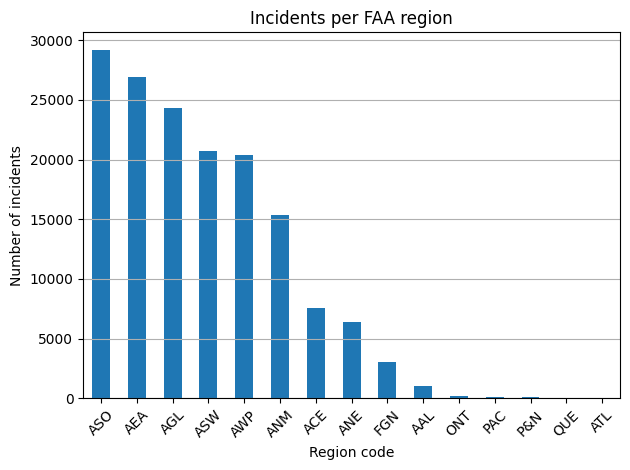

In [ ]:
df.groupby('FAA Region').size().sort_values(ascending=False).plot(kind='bar')
plt.title('Incidents per FAA region')
plt.ylabel('Number of incidents')
plt.xlabel('Region code')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

For reference, this is a map of major FAA regions:
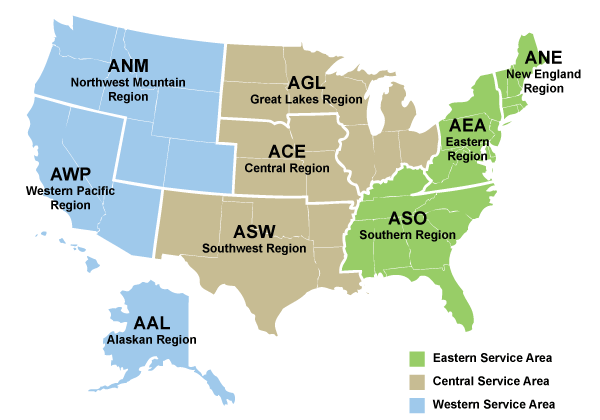

The amount of incidents in each major region is relatively uniform, and makes sense when taking into consideration the population of each region. It seems that there is no dominant region that could be causing such a high increase in incidents during the summer. Thus, it is hard using our limited data to pinpoint historical events or phenomena that would explain this increase.

Most likely, this increase is due to an inrease in awareness and FAA regulations detailing reports of Airplane wildlife strikes.

One major incident that took place during this time was the "Miracle on the Hudson". In 2009, US Airways Flight 1549 struck a flock of birds soon after takeoff and had to make an extremely diffucult, but successful emergency landing on the Hudson River. This event raised a lot of awareness regarding the risks of wildlife strikes.
(https://en.wikipedia.org/wiki/US_Airways_Flight_1549)

After this incident, the FAA made its wildlife strick database avaialable to the public, and strick reporting jumped 25% from 2008 to 2009. (https://icao.usmission.gov/fact-sheet-the-federal-aviation-administrations-faa-wildlife-hazard-mitigation-program/)

In addition, due to a few profilic military wildlife strikes during the 1990s, the FAA stricted its regulations on Wildlife Hazard Assesments for major airpots. If risks are found, then a Management Plan must be created.

All of these factors would explain the bumps in strike data that is seen over time.

I want to see if the types of species is drasitically different across region:

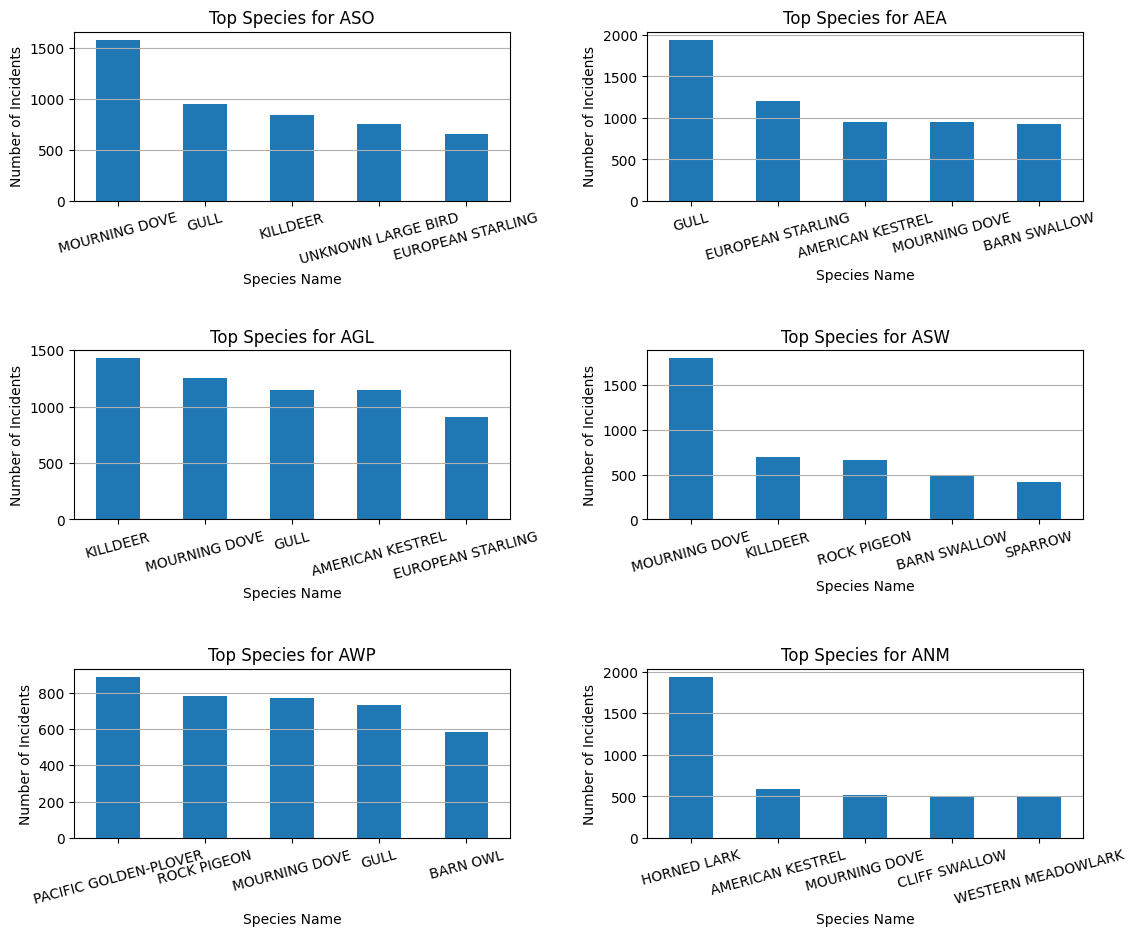

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Top 6 regions by bird strikes
top_regions = df['FAA Region'].value_counts().head(6).index.tolist()

for idx, region in enumerate(top_regions):
    ax = axes[idx // 2, idx % 2]

    # Filter out placeholder labels
    region_data = df[df['FAA Region'] == region]
    region_data = region_data[~region_data['Species Name'].isin(['UNKNOWN MEDIUM BIRD', 'UNKNOWN SMALL BIRD', 'UNKNOWN BIRD'])]

    # Get the top species for this region
    top_species = region_data['Species Name'].value_counts().head(5)

    top_species.plot(kind='bar', ax=ax)
    ax.set_title(f'Top Species for {region}')
    ax.set_ylabel('Number of Incidents')
    ax.set_xlabel('Species Name')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
    ax.grid(axis='y')

# Adjust spacing between plots
plt.tight_layout(pad=3.0)
plt.show()

Some regions are dominanted by specific species. This is useful to know for any predictive modeling, as it indicates that Region and Species are important features.

# Predictive Modelling

In this section, the goal is to predict damage type given a set of features from the data. We first take a look at the different damage indicators in the data.

<ipython-input-16-e4d9927b19d8>:3: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  incident_counts = df[damage_indicators].sum()


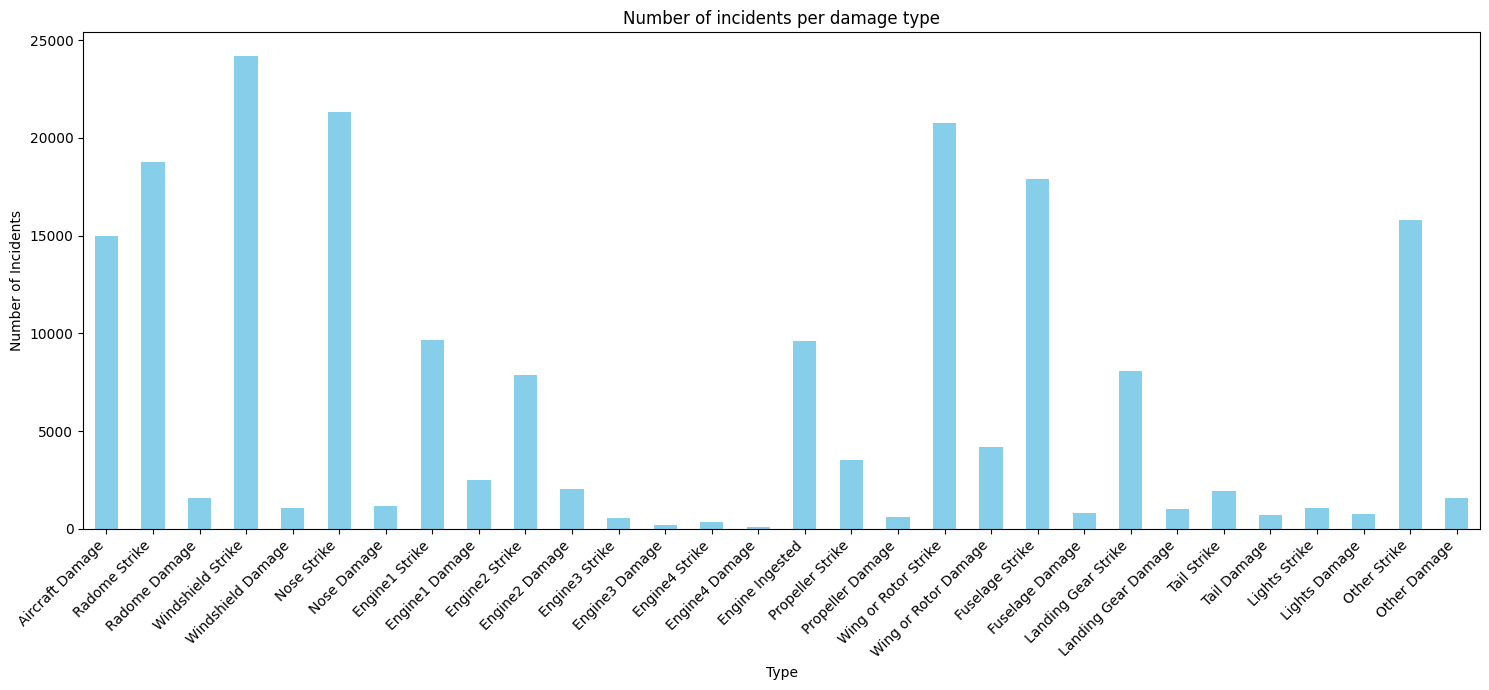

In [ ]:
damage_indicators = df.columns[df.columns.get_loc('Aircraft Damage'):]

incident_counts = df[damage_indicators].sum()

plt.figure(figsize=(15,7))
incident_counts.plot(kind='bar', color='skyblue')
plt.title('Number of incidents per damage type')
plt.ylabel('Number of Incidents')
plt.xlabel('Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

Predicting damages specifically will be more usefull in a real world scenario. Such a model would be able to identify risky conditions for preventative actions or guide response after a strike is detected.

In [ ]:
# getting columns for just the damage indicators
damage_columns = [col for col in df.columns if 'damage' in col.lower()]

damage_df = df[damage_columns]
damage_df.head()

,Aircraft Damage,Radome Damage,Windshield Damage,Nose Damage,Engine1 Damage,Engine2 Damage,Engine3 Damage,Engine4 Damage,Propeller Damage,Wing or Rotor Damage,Fuselage Damage,Landing Gear Damage,Tail Damage,Lights Damage,Other Damage
0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
damage_df.tail()

,Aircraft Damage,Radome Damage,Windshield Damage,Nose Damage,Engine1 Damage,Engine2 Damage,Engine3 Damage,Engine4 Damage,Propeller Damage,Wing or Rotor Damage,Fuselage Damage,Landing Gear Damage,Tail Damage,Lights Damage,Other Damage
174099,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
174100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
174101,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
174102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
174103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 1. Feature Procesing

We isolate important features and clean up the data so that it can be used for training.

In [ ]:
# Significant features
features = [
    "Incident Year", "Incident Month", "Incident Day",
    "Aircraft Type", "Aircraft Model", "Aircraft Mass",
    "Engine Type", "Engines", "Engine Make", "Engine Model",
    "Airport ID", "State", "FAA Region",
    "Flight Phase", "Visibility", "Precipitation", "Height", "Speed", "Distance",
    "Species ID",
    "Warning Issued",
]

# Features that need to be encoded into numerical values
categorical_features = ["Aircraft Type", "Engine Type", "Airport ID", "State", "FAA Region", "Flight Phase", "Warning Issued", "Visibility", "Precipitation", "Species ID",]

In [ ]:
for col in features:
    if col not in categorical_features:
        # Get rid of non-numerical values in otherwise numerical columns
        df[col] = pd.to_numeric(df[col], errors='coerce')

        # Replace null with median of col
        df[col].fillna(df[col].median(), inplace=True)

In [ ]:
le = LabelEncoder()
for col in categorical_features:
    df[col] = le.fit_transform(df[col])

X = df[features]
y = df[damage_columns]

# Split into train and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # This will result in 80% training, 10% validation, 10% test

# Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


## 2. Create Model

We will be defining a simple fully connected neural network in PyTorch to test.

In [ ]:
class DamagePredictorNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DamagePredictorNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 256)
        self.dropout = nn.Dropout(0.5)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, output_size)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.dropout(x)
        x = F.relu(self.layer3(x))
        x = torch.sigmoid(self.layer4(x))
        return x

## 3. Training
The model will be validated using Binary Cross Entropy Loss, as our labels consist of binary indicators.

In [ ]:
# Hyperparameters
learning_rate = 0.001
epochs = 25
batch_size = 128
input_size = len(features)
output_size = len(damage_columns)

# Conver data to right format
train_data = torch.tensor(X_train.astype('float32'))
train_labels = torch.tensor(y_train.astype('float32').values)
test_data = torch.tensor(X_test.astype('float32'))
test_labels = torch.tensor(y_test.astype('float32').values)
val_data = torch.tensor(X_val.astype('float32'))
val_labels = torch.tensor(y_val.astype('float32').values)


# DataLoader
train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(val_data, val_labels)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)


# Model, Loss, Optimizer
model = DamagePredictorNN(input_size=X_train.shape[1], output_size=y_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
loss_function = torch.nn.BCELoss()

# Loop
for epoch in range(epochs):
    # Training
    model.train()
    for i, (data, labels) in enumerate(train_loader):
        outputs = model(data)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_losses = []
        for data, labels in val_loader:
            outputs = model(data)
            val_loss = criterion(outputs, labels)
            val_losses.append(val_loss.item())

    avg_val_loss = sum(val_losses) / len(val_losses)

    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {avg_val_loss:.4f}")


Epoch [1/25], Training Loss: 0.0101, Validation Loss: 0.0476
Epoch [2/25], Training Loss: 0.0318, Validation Loss: 0.0466
Epoch [3/25], Training Loss: 0.0795, Validation Loss: 0.0465
Epoch [4/25], Training Loss: 0.0018, Validation Loss: 0.0464
Epoch [5/25], Training Loss: 0.0487, Validation Loss: 0.0457
Epoch [6/25], Training Loss: 0.0291, Validation Loss: 0.0455
Epoch [7/25], Training Loss: 0.0392, Validation Loss: 0.0460
Epoch [8/25], Training Loss: 0.0813, Validation Loss: 0.0456
Epoch [9/25], Training Loss: 0.0750, Validation Loss: 0.0455
Epoch [10/25], Training Loss: 0.0743, Validation Loss: 0.0451
Epoch [11/25], Training Loss: 0.0534, Validation Loss: 0.0450
Epoch [12/25], Training Loss: 0.0167, Validation Loss: 0.0450
Epoch [13/25], Training Loss: 0.0175, Validation Loss: 0.0450
Epoch [14/25], Training Loss: 0.0632, Validation Loss: 0.0453
Epoch [15/25], Training Loss: 0.0250, Validation Loss: 0.0453
Epoch [16/25], Training Loss: 0.0150, Validation Loss: 0.0450
Epoch [17/25], Tr

## 4. Testing
We test the model and print out summary statistics and graphs, to get a better understanding of how our model, and more importantly features, were able to predict damage.

In [ ]:
model.eval()

# 2. Predict on the test set
with torch.no_grad():
    predictions = model(test_data)
    predictions = (predictions > 0.5).float()  # Convert probabilities to binary outputs

# 3. Calculate evaluation metrics
accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions, average='weighted')
recall = recall_score(test_labels, predictions, average='weighted')
f1 = f1_score(test_labels, predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9058
Precision: 0.3976
Recall: 0.0995
F1 Score: 0.1532


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We can see that while the accuracy of the model is high, the low precision and recall scores indicate a large number of false positives/negatives. Most likely, the large amount of non-damage causing strikes is biasing the model, causing it to prefer to guess no damage. We can potentially fix this using modified sampling techniques.

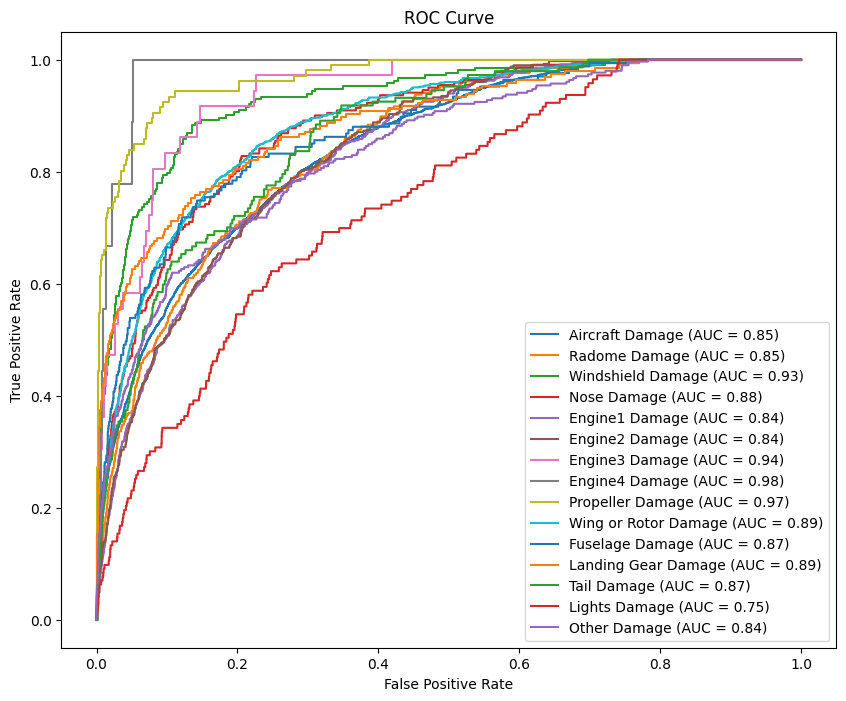

In [ ]:
# Plot seperate ROC curve for each indicator
def plot_roc_curve(y_true, y_pred_prob, label_names):
    plt.figure(figsize=(10, 8))

    for i, label in enumerate(label_names):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

with torch.no_grad():
    prediction_probs = model(test_data).numpy()

plot_roc_curve(test_labels, prediction_probs, damage_columns)


We can see that the ROC curves for all indicators are concave down. This leads to AUC (Area under curve) values of close to 1 in every case. However, this may also be due to the large imbalance in sample type, as mentioned before. One thing that is interesting to note is the low AUC value for "Lights Damage", despite it not being the least common type of damage.

To further analyse our model, it may be useful to display the most important features using a method called Perutation Importance. Here, features are shuffled and the resulting effect on test set accuracy is measured.

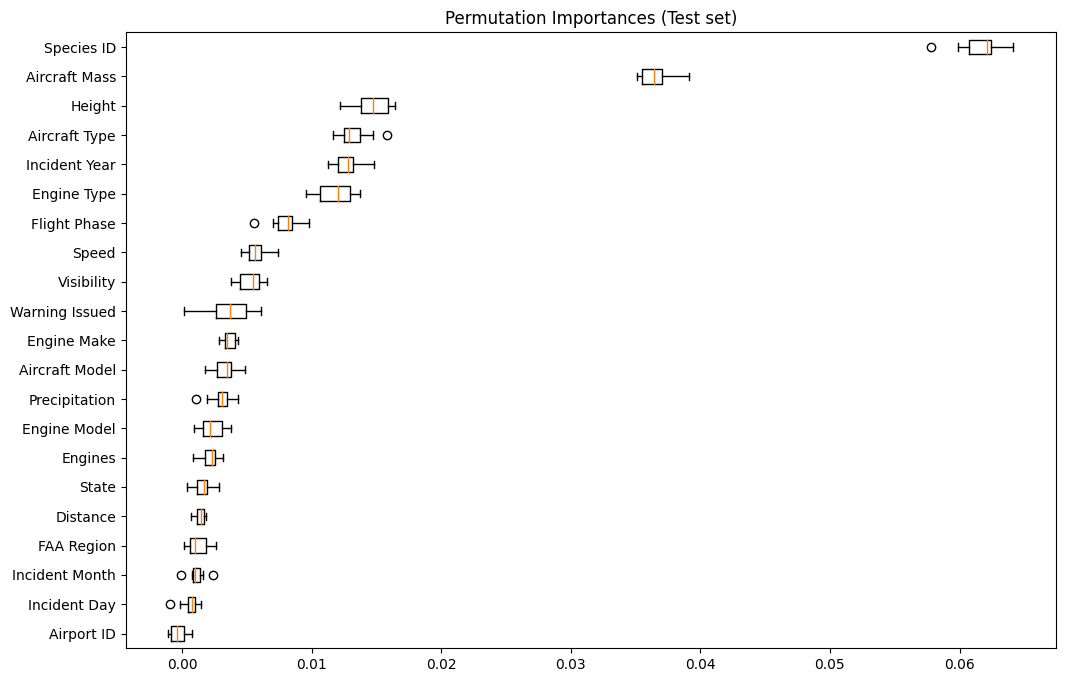

In [ ]:
# Required for the permutation importance method
class EstimatorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        # We won't define the fit method since our model is already trained.
        pass

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(torch.tensor(X.astype('float32')))
        return outputs.numpy()

wrapped_model = EstimatorWrapper(model)

# Call method
result = permutation_importance(wrapped_model, X_test, y_test, n_repeats=10)

# Sort by largest
sorted_idx = result.importances_mean.argsort()

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx])
plt.title("Permutation Importances (Test set)")
plt.show()


It seems that SpeciesID and Aircraft Mass have the largest scores by far. Note that a positive score means a decrease in accuracy when the respective feature was shuffled.

We already saw how the make-up of species that cause strikes varies drastically depending on region. Naturally, these insights can be used to assist with predictive measures further, as well as inform airports to improve their habitat control measures.